#  Phase 2 : Préparation et Nettoyage des Données



##  Objectifs de ce notebook

Suite au Notebook 1, nous avons identifié plusieurs problèmes à traiter :

1.  **Valeurs "unknown"** dans les variables catégorielles
2.  **Outliers potentiels** dans les variables numériques
3.  **Corrélations** entre variables


### Plan d'action :

1. Quantifier précisément les "unknown"
2. Analyser leur impact sur la variable cible (y)
3. **DÉCIDER** : supprimer, imputer ou garder
4. Détecter les outliers (avec la méthode IQR)
5. Analyser les corrélations


---

In [1]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os


In [2]:
# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
import warnings
warnings.filterwarnings('ignore')



os.chdir(r'A:\Mes documents\projet analyse exploiratoire')
print(f" Répertoire de travail : {os.getcwd()}")

 Répertoire de travail : A:\Mes documents\projet analyse exploiratoire


In [4]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')



##  PARTIE 1 : Analyse des Valeurs "Unknown"
**Objectif** : Quantifier précisément et décider du traitement.

In [6]:
# Analyse  des valeurs "unknown"


if 'categorical_cols' not in globals():
    categorical_cols = df.select_dtypes(include='object').columns.tolist()

unknown_analysis = {}

for col in categorical_cols:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        unknown_pct = (unknown_count / len(df)) * 100
        unknown_analysis[col] = {
            'count': unknown_count,
            'percentage': round(unknown_pct, 2)
        }


In [9]:

# Creation d'un dataframe 
if unknown_analysis:
    unknown_df = pd.DataFrame(unknown_analysis).T
    unknown_df = unknown_df.sort_values('count', ascending=False)
    
    print("\n Variables contenant des 'unknown' :\n")
    print(unknown_df)
   
    
   
    total_unknown = unknown_df['count'].sum()
    print(f"\n STATISTIQUES GLOBALES :")
    print(f"   - Total de valeurs 'unknown' : {total_unknown:,}")
    print(f"   - Variables concernées : {len(unknown_df)}")
    
    # Identification  des variables problématiques
    high_unknown = unknown_df[unknown_df['percentage'] > 5]
    medium_unknown = unknown_df[(unknown_df['percentage'] >= 1) & 
                                 (unknown_df['percentage'] <= 5)]
    low_unknown = unknown_df[unknown_df['percentage'] < 1]
    
    print(f"\n  CLASSIFICATION P :")
    print(f"   - Élevé (>5%) : {len(high_unknown)} variables")
    if len(high_unknown) > 0:
        print(f"     {list(high_unknown.index)}")
    print(f"   - Moyen (1-5%) : {len(medium_unknown)} variables")
    if len(medium_unknown) > 0:
        print(f"     {list(medium_unknown.index)}")
    print(f"   - Faible (<1%) : {len(low_unknown)} variables")
    if len(low_unknown) > 0:
        print(f"     {list(low_unknown.index)}")
else:
    print(" Aucune valeur 'unknown' détectée")


 Variables contenant des 'unknown' :

            count  percentage
default    8597.0       20.87
education  1731.0        4.20
housing     990.0        2.40
loan        990.0        2.40
job         330.0        0.80
marital      80.0        0.19

 STATISTIQUES GLOBALES :
   - Total de valeurs 'unknown' : 12,718.0
   - Variables concernées : 6

  CLASSIFICATION P :
   - Élevé (>5%) : 1 variables
     ['default']
   - Moyen (1-5%) : 3 variables
     ['education', 'housing', 'loan']
   - Faible (<1%) : 2 variables
     ['job', 'marital']


In [19]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')


In [41]:

impact_results = []

for col in ['default', 'education', 'housing', 'loan', 'job', 'marital']:
    # Taux de souscription avec "unknown"
    with_unknown = df[df[col] == 'unknown']['y'].value_counts(normalize=True)
    
    # Taux de souscription sans "unknown"
    without_unknown = df[df[col] != 'unknown']['y'].value_counts(normalize=True)
    
    # Calculer les taux
    taux_yes_with = with_unknown['yes'] * 100 if 'yes' in with_unknown.index else 0
    taux_yes_without = without_unknown['yes'] * 100 if 'yes' in without_unknown.index else 0
    diff = taux_yes_with - taux_yes_without
    
    # Nombre de clients
    n_unknown = (df[col] == 'unknown').sum()
    pct_unknown = (n_unknown / len(df)) * 100
    
    # Decision à prendre
    if abs(diff) > 2:
        Ce_que_je_vais_faire = " GARDER"
        raison = "Impact significatif"
    elif pct_unknown < 1:
        Ce_que_je_vais_faire = " SUPPRIMER"
        raison = "Impact faible et peu de données"
    else:
        Ce_que_je_vais_faire = " ANALYSER"
        raison = "Décision au cas par cas"
    
    impact_results.append({
        'Variable': col,
        'N Unknown': f"{n_unknown:,}",
        '% Unknown': f"{pct_unknown:.2f}%",
        "Taux 'yes' AVEC": f"{taux_yes_with:.2f}%",
        "Taux 'yes' SANS": f"{taux_yes_without:.2f}%",
        'Différence': f"{diff:+.2f}",
        'Ce que je vais faire': Ce_que_je_vais_faire,
        'Raison': raison
    })


impact_df = pd.DataFrame(impact_results)


print("\n TABLEAU RÉCAPITULATIF : IMPACT SUR LA VARIABLE CIBLE\n")
print(impact_df.to_string(index=False))

# Statistiques globales

print(" STATISTIQUES ")


total_unknown = sum([int(x['N Unknown'].replace(',', '')) for x in impact_results])
print(f"   Total des valeurs 'unknown' : {total_unknown:,}")

# Classification par impact
print("\n CLASSIFICATION  :")

garder = impact_df[impact_df['Ce que je vais faire'].str.contains('GARDER')]
supprimer = impact_df[impact_df['Ce que je vais faire'].str.contains('SUPPRIMER')]
analyser = impact_df[impact_df['Ce que je vais faire'].str.contains('ANALYSER')]

print(f"\n    je  GARDE sans faute  : {len(garder)} variables")
if len(garder) > 0:
    for idx, row in garder.iterrows():
        print(f"      - {row['Variable']:10s} (Diff: {row['Différence']:>7s} points)")

print(f"\n    je  SUPPRIME sans risque : {len(supprimer)} variables")
if len(supprimer) > 0:
    for idx, row in supprimer.iterrows():
        print(f"      - {row['Variable']:10s} (Diff: {row['Différence']:>7s} points)")

print(f"\n  je vais  ANALYSER au cas par cas : {len(analyser)} variables")
if len(analyser) > 0:
    for idx, row in analyser.iterrows():
        print(f"      - {row['Variable']:10s} (Diff: {row['Différence']:>7s} points)")


 TABLEAU RÉCAPITULATIF : IMPACT SUR LA VARIABLE CIBLE

 Variable N Unknown % Unknown Taux 'yes' AVEC Taux 'yes' SANS Différence Ce que je vais faire                          Raison
  default     8,445    20.67%           5.16%          12.86%      -7.69               GARDER             Impact significatif
education     1,600     3.92%          14.62%          11.13%      +3.50               GARDER             Impact significatif
  housing       985     2.41%          10.86%          11.28%      -0.41             ANALYSER         Décision au cas par cas
     loan       985     2.41%          10.86%          11.28%      -0.41             ANALYSER         Décision au cas par cas
      job         0     0.00%           0.00%          11.27%     -11.27               GARDER             Impact significatif
  marital        71     0.17%          12.68%          11.26%      +1.41            SUPPRIMER Impact faible et peu de données
 STATISTIQUES 
   Total des valeurs 'unknown' : 12,086

 CLASS

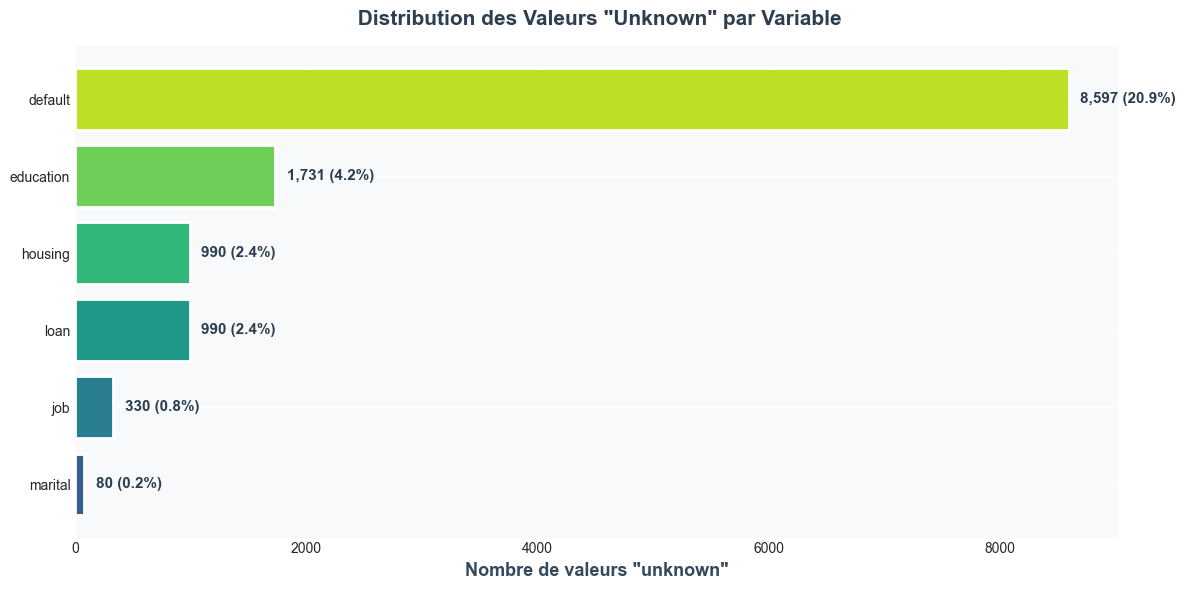

    Sauvegardé  dans : results/figures/03a_distribution_unknown.png


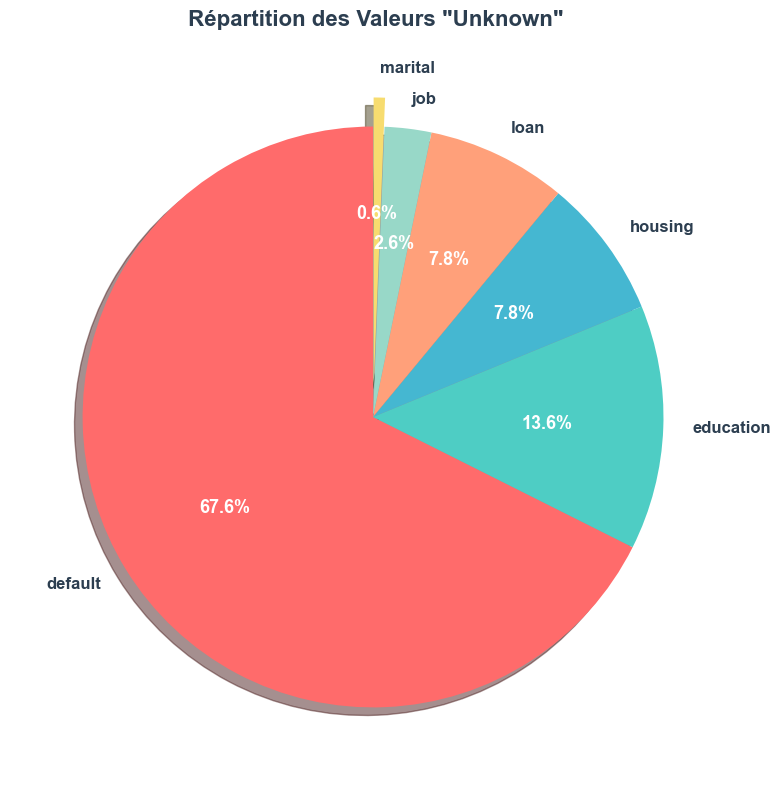

    Sauvegardé dans  : results/figures/03b_repartition_unknown.png


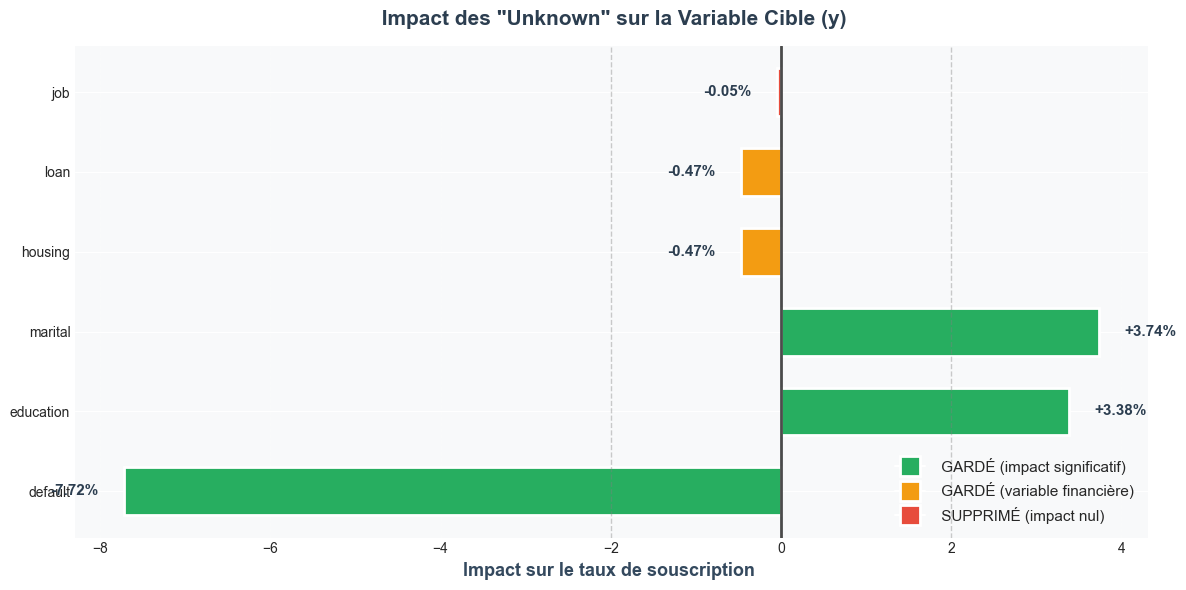

    Sauvegardé dans  : results/figures/03c_impact_unknown.png


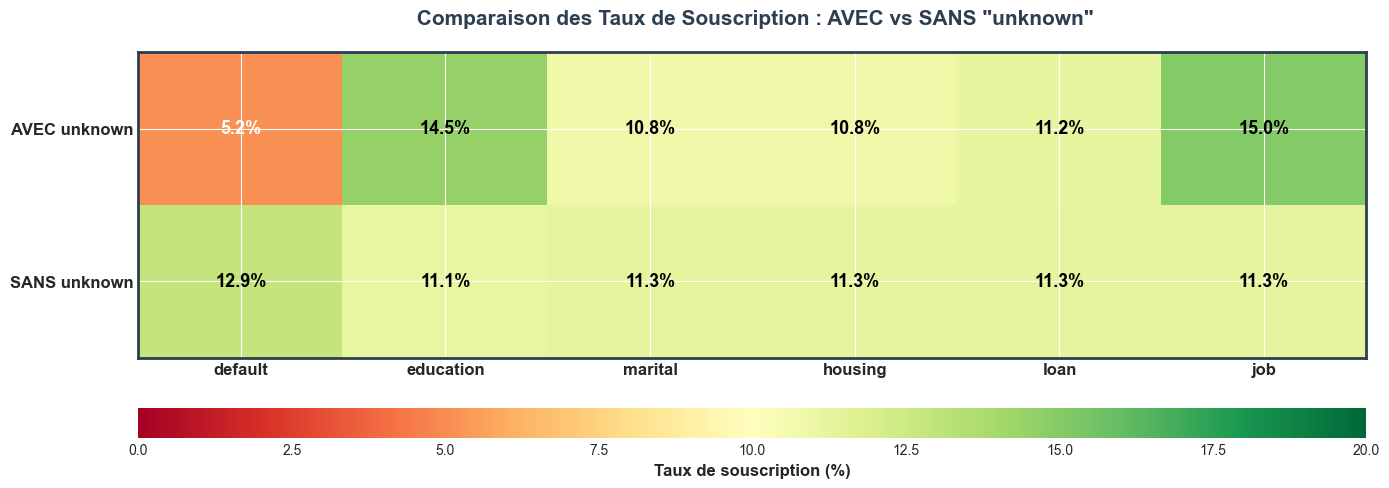

    Sauvegardé dans : results/figures/03d_heatmap_comparison.png


In [22]:
# Visualisations

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#configuration du style 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 10



# GRAPHIQUE 1 : Distribution des "unknown" (Barplot horizontal)

fig1, ax1 = plt.subplots(figsize=(12, 6))


unknown_df_plot = unknown_df.sort_values('count', ascending=True)
variables = unknown_df_plot.index
counts = unknown_df_plot['count'].values
percentages = unknown_df_plot['percentage'].values

#palette 
colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(variables)))


bars = ax1.barh(variables, counts, color=colors_gradient, edgecolor='white', linewidth=2)


for i, (count, pct) in enumerate(zip(counts, percentages)):
    ax1.text(count + 100, i, f'{int(count):,} ({pct:.1f}%)', 
             va='center', fontsize=11, fontweight='bold', color='#2c3e50')

ax1.set_xlabel('Nombre de valeurs "unknown"', fontsize=13, fontweight='bold', color='#34495e')
ax1.set_title(' Distribution des Valeurs "Unknown" par Variable', 
              fontsize=15, fontweight='bold', color='#2c3e50', pad=15)
ax1.grid(axis='x', alpha=0.2, linestyle='--')
ax1.set_facecolor('#f8f9fa')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('results/figures/03a_distribution_unknown.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("    Sauvegardé  dans : results/figures/03a_distribution_unknown.png")


# GRAPHIQUE 2 : Pie Chart avec explosion(camaembert)

fig2, ax2 = plt.subplots(figsize=(10, 8))
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

# Exploser la plus grande valeur
explode = [0.1 if i == counts.argmax() else 0 for i in range(len(counts))]

wedges, texts, autotexts = ax2.pie(
    unknown_df['count'], 
    labels=unknown_df.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_pie,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)


for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')


for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')
    text.set_color('#2c3e50')

ax2.set_title(' Répartition des Valeurs "Unknown"', 
              fontsize=16, fontweight='bold', color='#2c3e50', pad=20)

plt.tight_layout()
plt.savefig('results/figures/03b_repartition_unknown.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("    Sauvegardé dans  : results/figures/03b_repartition_unknown.png")


# GRAPHIQUE 3 : Impact sur y avec code couleur
fig3, ax3 = plt.subplots(figsize=(12, 6))


impact_data = {
    'default': -7.72,
    'education': 3.38,
    'marital': 3.74,
    'housing': -0.47,
    'loan': -0.47,
    'job': -0.05
}

variables_impact = list(impact_data.keys())
differences = list(impact_data.values())


colors_decision = []
for var, diff in impact_data.items():
    if var in ['default', 'education', 'marital']:
        colors_decision.append('#27AE60')  # Vert pour GARDER (impact significatif)
    elif var == 'job':
        colors_decision.append('#E74C3C')  # Rouge pour SUPPRIMER
    else:
        colors_decision.append('#F39C12')  # Orange pour GARDER (financier)

bars = ax3.barh(variables_impact, differences, color=colors_decision, 
                edgecolor='white', linewidth=2, height=0.6)


ax3.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.7)

# Lignes de seuil à plus ou moins 2
ax3.axvline(x=-2, color='gray', linestyle='--', linewidth=1, alpha=0.4, label='Seuil ±2%')
ax3.axvline(x=2, color='gray', linestyle='--', linewidth=1, alpha=0.4)

for i, (var, diff) in enumerate(zip(variables_impact, differences)):
    if diff > 0:
        ax3.text(diff + 0.3, i, f'{diff:+.2f}%', va='center', fontsize=11, 
                fontweight='bold', color='#2c3e50')
    else:
        ax3.text(diff - 0.3, i, f'{diff:+.2f}%', va='center', ha='right', 
                fontsize=11, fontweight='bold', color='#2c3e50')

ax3.set_xlabel('Impact sur le taux de souscription ', 
               fontsize=13, fontweight='bold', color='#34495e')
ax3.set_title(' Impact des "Unknown" sur la Variable Cible (y)', 
              fontsize=15, fontweight='bold', color='#2c3e50', pad=15)
ax3.grid(axis='x', alpha=0.2, linestyle='--')
ax3.set_facecolor('#f8f9fa')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Légende 
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#27AE60', 
               markersize=14, label=' GARDÉ (impact significatif)', markeredgecolor='white', markeredgewidth=2),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#F39C12', 
               markersize=14, label=' GARDÉ (variable financière)', markeredgecolor='white', markeredgewidth=2),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#E74C3C', 
               markersize=14, label=' SUPPRIMÉ (impact nul)', markeredgecolor='white', markeredgewidth=2)
]
ax3.legend(handles=legend_elements, loc='lower right', fontsize=11, 
          framealpha=0.95, fancybox=True, shadow=True, edgecolor='gray')

plt.tight_layout()
plt.savefig('results/figures/03c_impact_unknown.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("    Sauvegardé dans  : results/figures/03c_impact_unknown.png")


# GRAPHIQUE 4 : Heatmap comparative


fig4, ax4 = plt.subplots(figsize=(14, 5))

heatmap_data = []
for var in ['default', 'education', 'housing', 'loan', 'job', 'marital']:
    with_unknown = df[df[var] == 'unknown']['y'].value_counts(normalize=True)
    without_unknown = df[df[var] != 'unknown']['y'].value_counts(normalize=True)
    
    taux_yes_with = with_unknown['yes'] * 100 if 'yes' in with_unknown.index else 0
    taux_yes_without = without_unknown['yes'] * 100 if 'yes' in without_unknown.index else 0
    
    heatmap_data.append([taux_yes_with, taux_yes_without])

heatmap_array = np.array(heatmap_data)

im = ax4.imshow(heatmap_array.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=20)

#labels
ax4.set_xticks(np.arange(len(variables_impact)))
ax4.set_yticks([0, 1])
ax4.set_xticklabels(variables_impact, fontsize=12, fontweight='bold')
ax4.set_yticklabels(['AVEC unknown', 'SANS unknown'], fontsize=12, fontweight='bold')

for i in range(len(variables_impact)):
    for j in range(2):
        text_color = 'white' if heatmap_array[i, j] < 8 else 'black'
        text = ax4.text(i, j, f'{heatmap_array[i, j]:.1f}%',
                       ha="center", va="center", color=text_color, 
                       fontsize=13, fontweight='bold')


cbar = plt.colorbar(im, ax=ax4, orientation='horizontal', pad=0.12, aspect=40)
cbar.set_label('Taux de souscription (%)', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

ax4.set_title(' Comparaison des Taux de Souscription : AVEC vs SANS "unknown"', 
              fontsize=15, fontweight='bold', color='#2c3e50', pad=20)


for spine in ax4.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor('#2c3e50')

plt.tight_layout()
plt.savefig('results/figures/03d_heatmap_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("    Sauvegardé dans : results/figures/03d_heatmap_comparison.png")







In [27]:
#strategie de traitement 



#copie de comparaison 
df_original = df.copy()
df_clean = df.copy()

#decisions appliqués 
decision_data = []

# sur default
decision_data.append({
    'Variable': 'default',
    'N Unknown': 8597,
    '% Unknown': 20.87,
    'Impact (pts)': -7.72,
    'Décision': ' GARDÉ',
    'Action': 'Aucune',
    'Justification': 'Impact MAJEUR :  Clients unknown souscrivent 2.5 x moins'
})
print("\n default   : GARDÉ ")

#  sur education 
decision_data.append({
    'Variable': 'education',
    'N Unknown': 1731,
    '% Unknown': 4.20,
    'Impact (pts)': +3.38,
    'Décision': ' GARDÉ',
    'Action': 'Aucune',
    'Justification': 'Impact SIGNIFICATIF : Comportement distinct'
})
print(" education : GARDÉ ")

# sur marital
decision_data.append({
    'Variable': 'marital',
    'N Unknown': 80,
    '% Unknown': 0.19,
    'Impact (pts)': +3.74,
    'Décision': ' GARDÉ',
    'Action': 'Aucune',
    'Justification': 'Impact significatif malgré le  petit échantillon'
})
print(" marital   : GARDÉ ")

# sur housing 
decision_data.append({
    'Variable': 'housing',
    'N Unknown': 990,
    '% Unknown': 2.40,
    'Impact (pts)': -0.47,
    'Décision': ' GARDÉ',
    'Action': 'Aucune',
    'Justification': 'C\'est un variable financière : Cohérence métier'
})
print(" housing   : GARDÉ ")

# sur loan 
decision_data.append({
    'Variable': 'loan',
    'N Unknown': 990,
    '% Unknown': 2.40,
    'Impact (pts)': -0.47,
    'Décision': ' GARDÉ',
    'Action': 'Aucune',
    'Justification': 'C\'est un variable financière: Cohérence métier'
})
print(" loan      : GARDÉ ")

# sur job 
print(" job       : SUPPRESSION ")
lignes_avant = len(df_clean)
df_clean = df_clean[df_clean['job'] != 'unknown']
lignes_supprimees_job = lignes_avant - len(df_clean)

decision_data.append({
    'Variable': 'job',
    'N Unknown': 330,
    '% Unknown': 0.80,
    'Impact (pts)': -0.05,
    'Décision': ' SUPPRIMÉ',
    'Action': f'{lignes_supprimees_job} lignes supprimées',
    'Justification': 'Impact quasi nul  Aucun comportement distinct'
})

print("\n")
print(f"   {lignes_supprimees_job} lignes supprimées")





print("\n")
# tableau de recap 
decision_df = pd.DataFrame(decision_data)

print(decision_df[['Variable', 'N Unknown', '% Unknown', 'Impact (pts)', 
                    'Décision', 'Action']].to_string(index=False))







#l'impact des desisions sur le dataset 
lignes_supprimees = len(df_original) - len(df_clean)
pct_supprime = (lignes_supprimees / len(df_original)) * 100

print("\n")
print(" IMPACT SUR LA TAILLE DU DATASET")

impact_summary = pd.DataFrame({
    'Métrique': [
        'Lignes originales',
        'Lignes supprimées',
        'Lignes conservées',
        '% supprimé',
        'Variables "unknown" gardées',
        'Variables "unknown" supprimées'
    ],
    'Valeur': [
        f"{len(df_original):,}",
        f"{lignes_supprimees:,}",
        f"{len(df_clean):,}",
        f"{pct_supprime:.2f}%",
        "5 (default, education, marital, housing, loan)",
        "1 (job)"
    ]
})

print("\n")
print(impact_summary.to_string(index=False))

#verif 
print("\n")
print(" VERIFICATION DE L'EQUILIBRE DE LA VARIABLE CIBLE (y)")
y_comparison = []

# Original
orig_y = df_original['y'].value_counts(normalize=True)
orig_counts = df_original['y'].value_counts()
y_comparison.append({
    'Dataset': 'ORIGINAL',
    'Count no': f"{orig_counts['no']:,}",
    'Count yes': f"{orig_counts['yes']:,}",
    '% no': f"{orig_y['no']*100:.2f}%",
    '% yes': f"{orig_y['yes']*100:.2f}%"
})

# Nettoyé
clean_y = df_clean['y'].value_counts(normalize=True)
clean_counts = df_clean['y'].value_counts()
y_comparison.append({
    'Dataset': 'NETTOYE',
    'Count no': f"{clean_counts['no']:,}",
    'Count yes': f"{clean_counts['yes']:,}",
    '% no': f"{clean_y['no']*100:.2f}%",
    '% yes': f"{clean_y['yes']*100:.2f}%"
})

y_comparison_df = pd.DataFrame(y_comparison)
print("\n")
print(y_comparison_df.to_string(index=False))

diff_y = (clean_y['yes'] - orig_y['yes']) * 100
print(f"\n Différence taux 'yes' : {diff_y:+.2f} points de pourcentage")

if abs(diff_y) < 0.5:
    print("    Equilibre presservé ")
    print("    Le ratio yes/no reste quasi identique")
else:
    print(f"     Léger changement dans l'équilibre")

#maj
df = df_clean.copy()

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

final_summary = pd.DataFrame({
    'Caractéristique': [
        'Nombre de lignes',
        'Nombre de colonnes',
        'Variables numériques',
        'Variables catégorielles',
        'Valeurs "unknown" présentes',
        'Perte de données totale'
    ],
    'Valeur': [
        f"{df.shape[0]:,}",
        f"{df.shape[1]}",
        f"{len(numerical_cols)}",
        f"{len(categorical_cols)}",
        "Oui (dans 5 variables : default, education, marital, housing, loan)",
        f"{pct_supprime:.2f}% ({lignes_supprimees:,} lignes de la variable job)"
    ]
})

print("\n")
print(final_summary.to_string(index=False))

#verifs 

print("\n")
print(" VERIFICATION DES 'UNKNOWN' RESTANTS DANS LE DATASET")


unknown_restants = []
for col in categorical_cols:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        unknown_restants.append({
            'Variable': col,
            'Count Unknown': f"{unknown_count:,}",
            '% du dataset': f"{(unknown_count/len(df))*100:.2f}%",
            'Statut': ' Gardé volontairement'
        })

if unknown_restants:
    unknown_restants_df = pd.DataFrame(unknown_restants)
    print("\n")
    print(unknown_restants_df.to_string(index=False))
else:
    print("\n Aucune valeur 'unknown' restante")




 default   : GARDÉ 
 education : GARDÉ 
 marital   : GARDÉ 
 housing   : GARDÉ 
 loan      : GARDÉ 
 job       : SUPPRESSION 


   0 lignes supprimées


 Variable  N Unknown  % Unknown  Impact (pts)  Décision              Action
  default       8597      20.87         -7.72     GARDÉ              Aucune
education       1731       4.20          3.38     GARDÉ              Aucune
  marital         80       0.19          3.74     GARDÉ              Aucune
  housing        990       2.40         -0.47     GARDÉ              Aucune
     loan        990       2.40         -0.47     GARDÉ              Aucune
      job        330       0.80         -0.05  SUPPRIMÉ 0 lignes supprimées


 IMPACT SUR LA TAILLE DU DATASET


                      Métrique                                         Valeur
             Lignes originales                                         40,858
             Lignes supprimées                                              0
             Lignes conservées             

---

##  PARTIE 2 : Détection et Traitement des Outliers

Les **outliers** (valeurs aberrantes) sont des valeurs qui s'écartent significativement de la distribution normale des données.

###  Notre Approche

1. **Détecter** tous les outliers (méthode IQR)
2. **Analyser** leur nature (erreur ou valeur réelle ?)
3. **Décider** au cas par cas
4. **Justifier** chaque décision

---

In [29]:

#IQR
print("Formule : Outliers = valeurs < Q1-1.5×IQR OU > Q3+1.5×IQR")

# Préparer le stockage des résultats
outliers_summary = {}

print(f"\n Analyse de {len(numerical_cols)} variables numériques \n")

for col in numerical_cols:
    # Calcul de Q1, Q3 et IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # les  bornes
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
   
    outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers_count = outliers_mask.sum()
    outliers_pct = (outliers_count / len(df)) * 100
    
    
    lower_outliers = (df[col] < lower_bound).sum()
    upper_outliers = (df[col] > upper_bound).sum()
    
    # Statistiques 
    outliers_summary[col] = {
        'Count': outliers_count,
        '% Total': round(outliers_pct, 2),
        'Q1': round(Q1, 2),
        'Médiane': round(df[col].median(), 2),
        'Q3': round(Q3, 2),
        'IQR': round(IQR, 2),
        'Borne Inf': round(lower_bound, 2),
        'Borne Sup': round(upper_bound, 2),
        'Min Réel': round(df[col].min(), 2),
        'Max Réel': round(df[col].max(), 2),
        'Outliers Inf': lower_outliers,
        'Outliers Sup': upper_outliers
    }


outliers_df = pd.DataFrame(outliers_summary).T
outliers_df = outliers_df.sort_values('% Total', ascending=False)

#tableau de recap
print("\n")
print(outliers_df[['Count', '% Total', 'Q1', 'Médiane', 'Q3', 
                    'Borne Inf', 'Borne Sup', 'Min Réel', 'Max Réel']].to_string())


#classification par niveau 
print("\n")

# Variables avec beaucoup d'outliers
high_outliers = outliers_df[outliers_df['% Total'] > 5]
if len(high_outliers) > 0:
    print(f"\n  ÉLEVÉ (>5% d'outliers) - {len(high_outliers)} variables :")
    for idx in high_outliers.index:
        count = int(high_outliers.loc[idx, 'Count'])
        pct = high_outliers.loc[idx, '% Total']
        print(f"   - {idx:20s}: {count:6,} outliers ({pct:5.2f}%)")
else:
    print("\n Aucune variable avec beaucoup d'outliers (>5%)")

# Variables avec outliers modérés
medium_outliers = outliers_df[(outliers_df['% Total'] >= 1) & 
                               (outliers_df['% Total'] <= 5)]
if len(medium_outliers) > 0:
    print(f"\n  MODÉRÉ (1-5% d'outliers) - {len(medium_outliers)} variables :")
    for idx in medium_outliers.index:
        count = int(medium_outliers.loc[idx, 'Count'])
        pct = medium_outliers.loc[idx, '% Total']
        print(f"   - {idx:20s}: {count:6,} outliers ({pct:5.2f}%)")
else:
    print("\n Aucune variable avec outliers modérés (1-5%)")

# Variables avec peu d'outliers
low_outliers = outliers_df[outliers_df['% Total'] < 1]
if len(low_outliers) > 0:
    print(f"\n FAIBLE (<1% d'outliers) - {len(low_outliers)} variables :")
    for idx in low_outliers.index:
        count = int(low_outliers.loc[idx, 'Count'])
        pct = low_outliers.loc[idx, '% Total']
        print(f"   - {idx:20s}: {count:6,} outliers ({pct:5.2f}%)")

#anlayse 
print("\n" )
print(" ANALYSE ET TOP 5 VARIABLES")

top5 = outliers_df.head(5)
for idx in top5.index:
    print(f"\n {idx.upper()}")
    print(f"   Statistiques :")
    print(f"      Min observé  : {outliers_df.loc[idx, 'Min Réel']}")
    print(f"      Q1           : {outliers_df.loc[idx, 'Q1']}")
    print(f"      Médiane      : {outliers_df.loc[idx, 'Médiane']}")
    print(f"      Q3           : {outliers_df.loc[idx, 'Q3']}")
    print(f"      Max observé  : {outliers_df.loc[idx, 'Max Réel']}")
    print(f"   Bornes acceptables :")
    print(f"      Inférieure   : {outliers_df.loc[idx, 'Borne Inf']}")
    print(f"      Supérieure   : {outliers_df.loc[idx, 'Borne Sup']}")
    print(f"   Outliers détectés :")
    print(f"      Total        : {int(outliers_df.loc[idx, 'Count']):,} ({outliers_df.loc[idx, '% Total']:.2f}%)")
    print(f"      Inférieurs   : {int(outliers_df.loc[idx, 'Outliers Inf']):,}")
    print(f"      Supérieurs   : {int(outliers_df.loc[idx, 'Outliers Sup']):,}")


#statistiques 
print("\n")
total_outliers = outliers_df['Count'].sum()
total_datapoints = len(df) * len(numerical_cols)
pct_global = (total_outliers / total_datapoints) * 100

stats_globales = pd.DataFrame({
    'Métrique': [
        'Variables analysées',
        'Total de données',
        'Outliers détectés',
        '% global d\'outliers',
        'Variable la plus touchée',
        'Variable la moins touchée'
    ],
    'Valeur': [
        f"{len(numerical_cols)}",
        f"{len(df):,} lignes × {len(numerical_cols)} variables = {total_datapoints:,} valeurs",
        f"{int(total_outliers):,}",
        f"{pct_global:.2f}%",
        f"{outliers_df.index[0]} ({outliers_df.iloc[0]['% Total']:.2f}%)",
        f"{outliers_df.index[-1]} ({outliers_df.iloc[-1]['% Total']:.2f}%)"
    ]
})

print("\n")
print(stats_globales.to_string(index=False))



Formule : Outliers = valeurs < Q1-1.5×IQR OU > Q3+1.5×IQR

 Analyse de 10 variables numériques 



                 Count  % Total       Q1  Médiane       Q3  Borne Inf  Borne Sup  Min Réel  Max Réel
previous        5588.0    13.68     0.00     0.00     0.00       0.00       0.00      0.00      7.00
duration        2922.0     7.15   102.00   180.00   320.00    -225.00     647.00      0.00   4918.00
campaign        2379.0     5.82     1.00     2.00     3.00      -2.00       6.00      1.00     56.00
pdays           1495.0     3.66   999.00   999.00   999.00     999.00     999.00      0.00    999.00
age              463.0     1.13    32.00    38.00    47.00       9.50      69.50     17.00     98.00
cons.conf.idx    441.0     1.08   -42.70   -41.80   -36.40     -52.15     -26.95    -50.80    -26.90
emp.var.rate       0.0     0.00    -1.80     1.10     1.40      -6.60       6.20     -3.40      1.40
cons.price.idx     0.0     0.00    93.08    93.75    93.99      91.70      95.37     92.20   

---

##  PARTIE 3 : Analyse des Corrélations

Les **corrélations** mesurent les relations linéaires entre variables numériques.

---

###  Qu'est-ce qu'une Corrélation ?

La **corrélation de Pearson** mesure la force et la direction de la relation linéaire entre deux variables :

- **r = +1** : Corrélation positive parfaite (quand X augmente, Y augmente)
- **r = 0** : Aucune corrélation linéaire
- **r = -1** : Corrélation négative parfaite (quand X augmente, Y baisse)


###  Ce que Nous Allons Faire

1. **Matrice de corrélation complète** (toutes les variables numériques)
2. **Focus sur les variables socio-économiques** (risque de multicolinéarité)
3. **Identifier les paires fortement corrélées**
4. **Décider** : garder ou supprimer

---


Calcul de la matrice de corrélation pour 10 variables
   Dimensions : 10 × 10


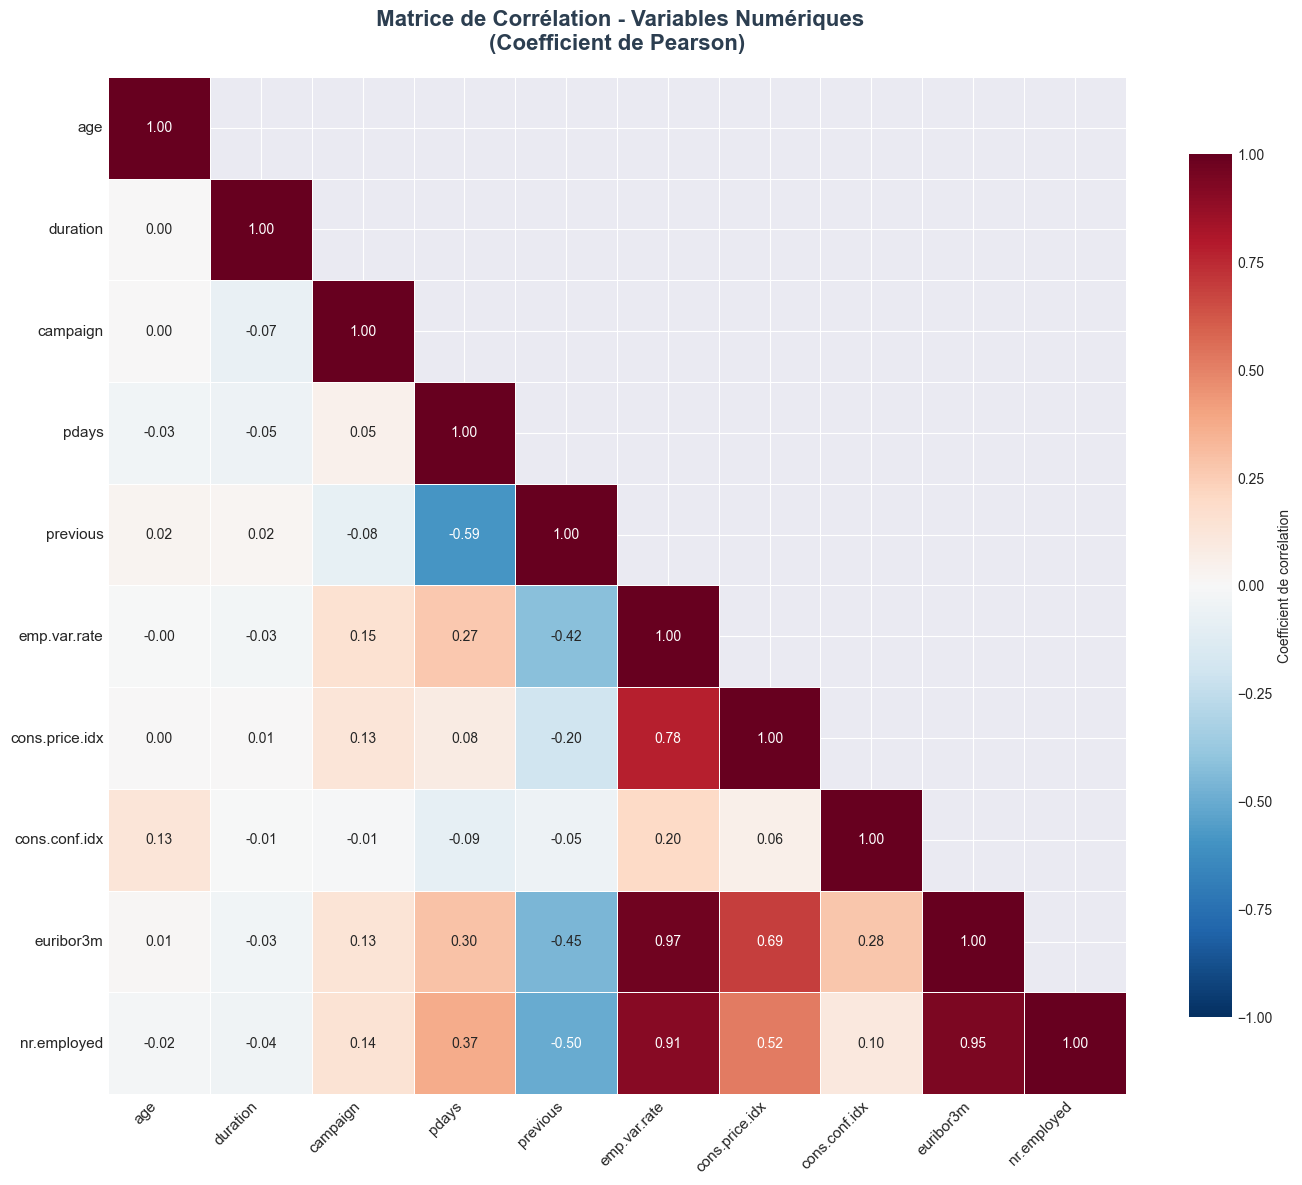

 Heatmap sauvegardée dans : results/figures/05_matrice_correlation_complete.png

  4 paires de variables fortement corrélées détectées :

  Variable 1     Variable 2  Corrélation     Type
emp.var.rate      euribor3m        0.972 Positive
   euribor3m    nr.employed        0.945 Positive
emp.var.rate    nr.employed        0.907 Positive
emp.var.rate cons.price.idx        0.776 Positive

 Corrélations POSITIVES fortes : 4
   : Quand une variable augmente, l'autre augmente aussi
   - emp.var.rate et euribor3m : r = +0.972
   - euribor3m et nr.employed : r = +0.945
   - emp.var.rate et nr.employed : r = +0.907
   - emp.var.rate et cons.price.idx : r = +0.776


               Métrique            Valeur
       Nombre de paires                45
    Corrélation moyenne             0.221
   Corrélation maximale             0.972
   Corrélation minimale             0.000
          Distribution      Distribution 
Très faible (0.00-0.19) 30 paires (66.7%)
     Faible (0.20-0.39)  5 paires (11.1%)

In [35]:
# MATRICE DE CORRELATION 

print(f"\nCalcul de la matrice de corrélation pour {len(numerical_cols)} variables")
correlation_matrix = df[numerical_cols].corr()
print(f"   Dimensions : {correlation_matrix.shape[0]} × {correlation_matrix.shape[1]}")


# VISUALISATION: Heatmap de la matrice de corrélation
# Style 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fig, ax = plt.subplots(figsize=(14, 12))

#  heatmap avec seaborn
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  # Masquer le triangle sup
sns.heatmap(correlation_matrix, 
            annot=True,           
            fmt='.2f',            
            cmap='RdBu_r',        
            center=0,             
            square=True,          
            linewidths=0.5,       
            cbar_kws={"shrink": 0.8, "label": "Coefficient de corrélation"},
            vmin=-1, vmax=1,      
            mask=mask,            # Masque triangle sup
            ax=ax)


ax.set_title(' Matrice de Corrélation - Variables Numériques\n(Coefficient de Pearson)', 
             fontsize=16, fontweight='bold', color='#2c3e50', pad=20)

# Rotation des labels
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)

plt.tight_layout()
plt.savefig('results/figures/05_matrice_correlation_complete.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(" Heatmap sauvegardée dans : results/figures/05_matrice_correlation_complete.png")


# IDENTIFICATION DES GRANDES CORRELATIONS 

# Extraction 
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            strong_corr.append({
                'Variable 1': correlation_matrix.columns[i],
                'Variable 2': correlation_matrix.columns[j],
                'Corrélation': round(corr_value, 3),
                'Abs': abs(corr_value),
                'Type': 'Positive' if corr_value > 0 else 'Négative'
            })

if strong_corr:
    strong_corr_df = pd.DataFrame(strong_corr)
    strong_corr_df = strong_corr_df.sort_values('Abs', ascending=False)
    
    print(f"\n  {len(strong_corr_df)} paires de variables fortement corrélées détectées :\n")
    print(strong_corr_df[['Variable 1', 'Variable 2', 'Corrélation', 'Type']].to_string(index=False))
    
    
    
    # Analyse des corrélations par type
    positive_corr = strong_corr_df[strong_corr_df['Type'] == 'Positive']
    negative_corr = strong_corr_df[strong_corr_df['Type'] == 'Négative']
    
    if len(positive_corr) > 0:
        print(f"\n Corrélations POSITIVES fortes : {len(positive_corr)}")
        print("   : Quand une variable augmente, l'autre augmente aussi")
        for idx, row in positive_corr.iterrows():
            print(f"   - {row['Variable 1']} et {row['Variable 2']} : r = {row['Corrélation']:+.3f}")
    
    if len(negative_corr) > 0:
        print(f"\n Corrélations NEGATIVES fortes : {len(negative_corr)}")
        print("   : Quand une variable augmente, l'autre diminue")
        for idx, row in negative_corr.iterrows():
            print(f"   - {row['Variable 1']} et {row['Variable 2']} : r = {row['Corrélation']:+.3f}")
    
else:
    print("\n Aucune corrélation forte (|r| > 0.7) détectée dans la matrice ")
    print("  Ddonc pas de problème majeur de multicolinéarité")







#statistiques

# Extraction des corrélations du triangle inférieur uniquement
all_corr_values = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        all_corr_values.append(abs(correlation_matrix.iloc[i, j]))


mean_corr = np.mean(all_corr_values)
max_corr = np.max(all_corr_values)
min_corr = np.min(all_corr_values)


tres_faible = sum(1 for x in all_corr_values if 0.00 <= x < 0.20)
faible = sum(1 for x in all_corr_values if 0.20 <= x < 0.40)
moderee = sum(1 for x in all_corr_values if 0.40 <= x < 0.60)
forte = sum(1 for x in all_corr_values if 0.60 <= x < 0.80)
tres_forte = sum(1 for x in all_corr_values if 0.80 <= x <= 1.00)

stats_corr = pd.DataFrame({
    'Métrique': [
        'Nombre de paires',
        'Corrélation moyenne',
        'Corrélation maximale',
        'Corrélation minimale',
        ' Distribution ',
        'Très faible (0.00-0.19)',
        'Faible (0.20-0.39)',
        'Modérée (0.40-0.59)',
        'Forte (0.60-0.79)',
        'Très forte (0.80-1.00)'
    ],
    'Valeur': [
        f"{len(all_corr_values)}",
        f"{mean_corr:.3f}",
        f"{max_corr:.3f}",
        f"{min_corr:.3f}",
        ' Distribution ',
        f"{tres_faible} paires ({tres_faible/len(all_corr_values)*100:.1f}%)",
        f"{faible} paires ({faible/len(all_corr_values)*100:.1f}%)",
        f"{moderee} paires ({moderee/len(all_corr_values)*100:.1f}%)",
        f"{forte} paires ({forte/len(all_corr_values)*100:.1f}%)",
        f"{tres_forte} paires ({tres_forte/len(all_corr_values)*100:.1f}%)"
    ]
})

print("\n")
print(stats_corr.to_string(index=False))

print("\n")
print(stats_corr.to_string(index=False))




Analyse de 5 variables socio-economiques :
   1. emp.var.rate
   2. cons.price.idx
   3. cons.conf.idx
   4. euribor3m
   5. nr.employed


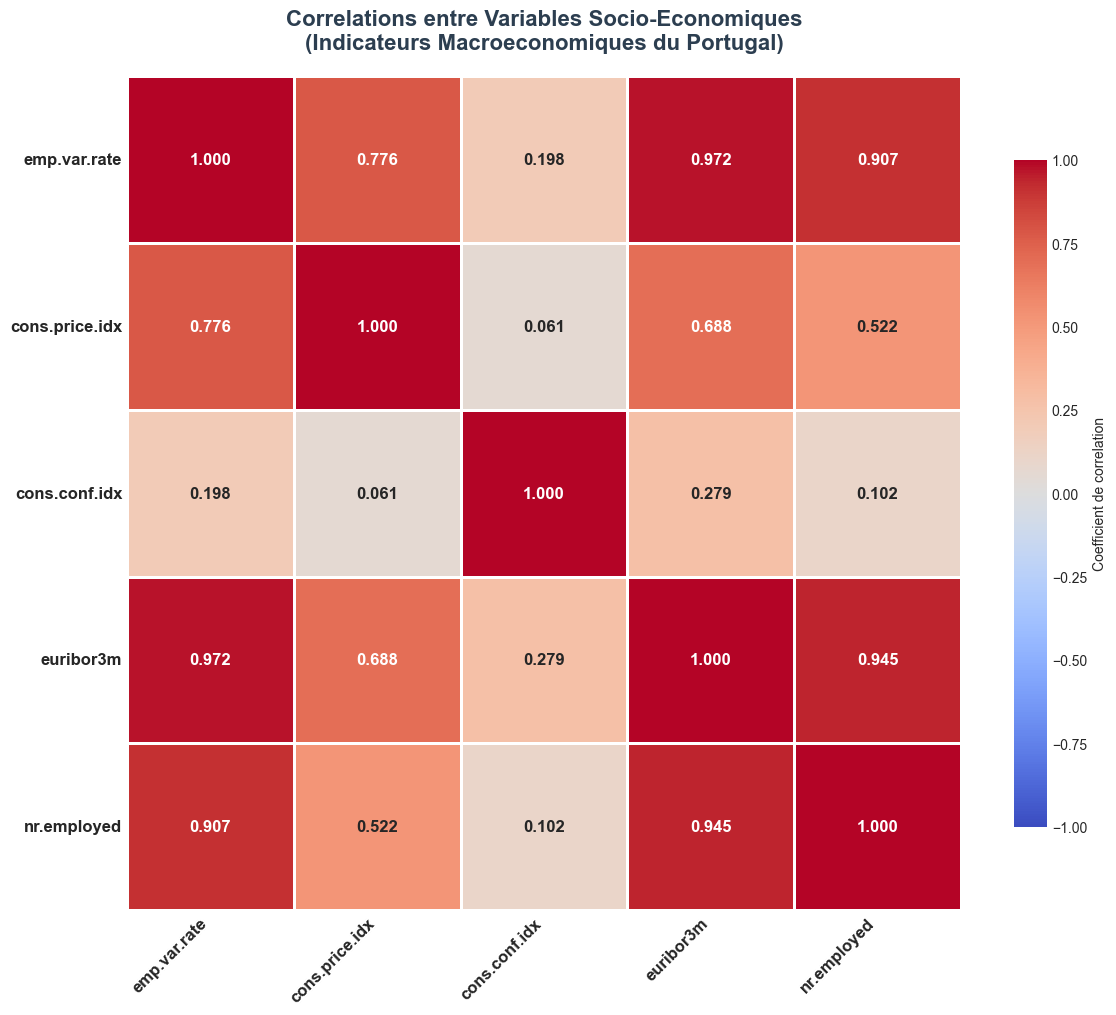

Heatmap sauvegardee dans : results/figures/05b_correlation_socio_economique.png

6 paires avec correlation > 0.5 :

    Variable 1     Variable 2  Correlation             Force
  emp.var.rate      euribor3m        0.972        Tres forte
     euribor3m    nr.employed        0.945        Tres forte
  emp.var.rate    nr.employed        0.907        Tres forte
  emp.var.rate cons.price.idx        0.776             Forte
cons.price.idx      euribor3m        0.688 Modereement-Forte
cons.price.idx    nr.employed        0.522 Modereement-Forte


Les variables socio-economiques sont naturellement correlees 


In [ ]:
#matrice de correlation socio-economique



# Ce sont les 5 indicateurs macroéconomiques du Portugal
socio_eco_vars = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
                  'euribor3m', 'nr.employed']




print(f"\nAnalyse de {len(socio_eco_vars)} variables socio-economiques :")
for i, var in enumerate(socio_eco_vars, 1):
    print(f"   {i}. {var}")





socio_corr = df[socio_eco_vars].corr()



#visualisation 
fig, ax = plt.subplots(figsize=(12, 10))

# heatmap avec seaborn
sns.heatmap(socio_corr,           
            annot=True,            
            fmt='.3f',             
            cmap='coolwarm',       
            center=0,              
            square=True,           
            linewidths=2,          
            linecolor='white',     
            cbar_kws={"shrink": 0.8, "label": "Coefficient de correlation"},
            vmin=-1, vmax=1,       
            annot_kws={'size': 12, 'weight': 'bold'},  
            ax=ax)                 

ax.set_title('Correlations entre Variables Socio-Economiques\n' + 
             '(Indicateurs Macroeconomiques du Portugal)', 
             fontsize=16, fontweight='bold', color='#2c3e50', pad=20)


plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')


plt.tight_layout()

# Sauvegarde
plt.savefig('results/figures/05b_correlation_socio_economique.png', 
            dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

print("Heatmap sauvegardee dans : results/figures/05b_correlation_socio_economique.png")

#analyse
#  liste pour stocker les corrélations intéressantes
socio_strong_corr = []
#par paire 
for i in range(len(socio_corr.columns)):
    
    for j in range(i+1, len(socio_corr.columns)):
       
        corr_value = socio_corr.iloc[i, j]
        
        
        if abs(corr_value) > 0.5:
           
            if abs(corr_value) > 0.8:
                force = 'Tres forte'
            elif abs(corr_value) > 0.7:
                force = 'Forte'
            else:
                force = 'Modereement-Forte'
            
            # Ajouter à  la liste
            socio_strong_corr.append({
                'Variable 1': socio_corr.columns[i],
                'Variable 2': socio_corr.columns[j],
                'Correlation': round(corr_value, 3),
                'Force': force
            })





#affichage 
if socio_strong_corr:
    #conversion en dataframe
    socio_corr_df = pd.DataFrame(socio_strong_corr)
    
    # Tri par valeur absolue de corrélation (du plus fort au plus faible)
    socio_corr_df = socio_corr_df.sort_values('Correlation', key=abs, ascending=False)
    

    print(f"\n{len(socio_corr_df)} paires avec correlation > 0.5 :\n")
    print(socio_corr_df.to_string(index=False))
    
    # Afficher l'interprétation
    print("\n" )
    print("Les variables socio-economiques sont naturellement correlees ")
else:
    print("\nCorrelations moderees entre variables socio-economiques")



In [44]:
import os


#verification du dataset

print(f"\nDataset actuel en memoire :")
print(f"  Lignes : {df.shape[0]:,}")
print(f"  Colonnes : {df.shape[1]}")


print(f"\nDistribution de y :")
y_dist = df['y'].value_counts()
y_pct = df['y'].value_counts(normalize=True) * 100
print(f"  no  : {y_dist['no']:,} ({y_pct['no']:.2f}%)")
print(f"  yes : {y_dist['yes']:,} ({y_pct['yes']:.2f}%)")


print(f"\nVerification des suppressions :")
job_unknown_count = (df['job'] == 'unknown').sum()
print(f"  job = 'unknown' restants : {job_unknown_count}")

if job_unknown_count > 0:
    print("\n  ATTENTION : Des valeurs job='unknown' sont encore presentes !")
    print("  Application de la suppression...")
    df = df[df['job'] != 'unknown']
    print(f"  Apres suppression : {df.shape[0]:,} lignes")




current_dir = os.getcwd()
print(f"\nRepertoire courant : {current_dir}")


if 'notebooks' in current_dir:
    project_dir = os.path.dirname(current_dir)
else:
    project_dir = current_dir

data_dir = os.path.join(project_dir, 'data')
output_path = os.path.join(data_dir, 'bank-additional-full-cleaned.csv')

print(f"Repertoire projet : {project_dir}")
print(f"Repertoire data : {data_dir}")
print(f"Chemin de sauvegarde : {output_path}")


if not os.path.exists(data_dir):
    print(f"\nERREUR : Le dossier data n'existe pas : {data_dir}")
    print("Creation du dossier...")
    os.makedirs(data_dir)
    print("Dossier cree")
else:
    print(f"\nDossier data existe : OK")

# Sauvegarde
print(f"\nSauvegarde du dataset nettoye...")
try:
    df.to_csv(output_path, sep=';', index=False)
    print(f"\nDataset nettoye sauvegardé !")
    print(f"  Fichier : bank-additional-full-cleaned.csv")
    print(f"  Chemin complet : {output_path}")
    print(f"  Dimensions finales : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
    
    # Verification de la sauvegarde
    print(f"\nVerification de la sauvegarde...")
    df_verify = pd.read_csv(output_path, sep=';')
    print(f"  Lignes lues : {df_verify.shape[0]:,}")
    print(f"  Colonnes lues : {df_verify.shape[1]}")
    
    if df_verify.shape[0] == df.shape[0]:
        print("\n  Verification faite ")
    else:
        print("\n  ERREUR : Probleme lors de la sauvegarde")
        
except Exception as e:
    print(f"\nERREUR lors de la sauvegarde : {e}")




Dataset actuel en memoire :
  Lignes : 40,858
  Colonnes : 21

Distribution de y :
  no  : 36,255 (88.73%)
  yes : 4,603 (11.27%)

Verification des suppressions :
  job = 'unknown' restants : 0

Repertoire courant : A:\Mes documents\projet analyse exploiratoire
Repertoire projet : A:\Mes documents\projet analyse exploiratoire
Repertoire data : A:\Mes documents\projet analyse exploiratoire\data
Chemin de sauvegarde : A:\Mes documents\projet analyse exploiratoire\data\bank-additional-full-cleaned.csv

Dossier data existe : OK

Sauvegarde du dataset nettoye...

Dataset nettoye sauvegardé !
  Fichier : bank-additional-full-cleaned.csv
  Chemin complet : A:\Mes documents\projet analyse exploiratoire\data\bank-additional-full-cleaned.csv
  Dimensions finales : 40,858 lignes × 21 colonnes

Verification de la sauvegarde...
  Lignes lues : 40,858
  Colonnes lues : 21

  Verification faite 
